In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


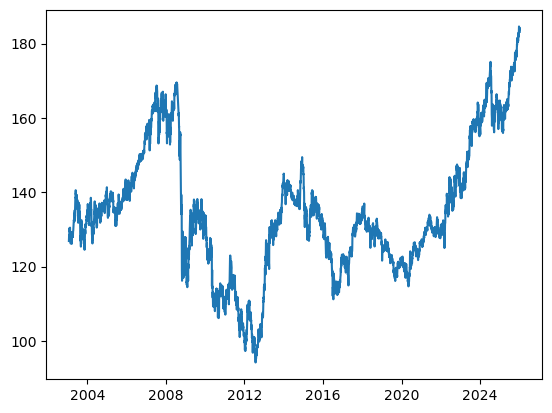

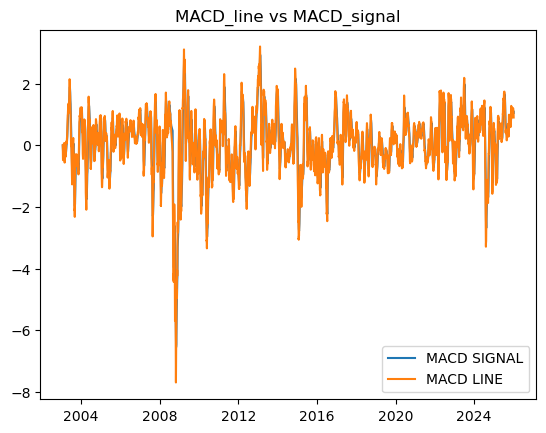

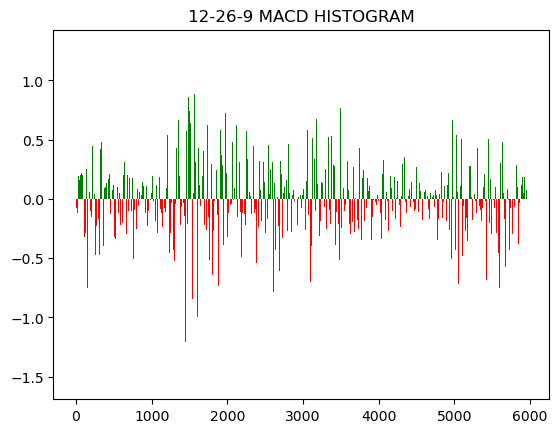

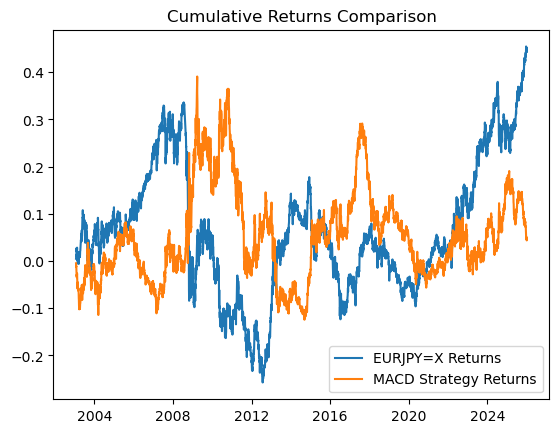

Price            Close        High         Low        Open  Volume  \
Date                                                                 
2025-12-30  183.690002  184.082993  183.410004  183.608994       0   
2025-12-31  183.720001  184.233994  183.548996  183.671997       0   
2026-01-02  184.162994  184.423996  183.712006  184.181000       0   
2026-01-05  183.746994  184.031998  182.809998  183.744003       0   
2026-01-06  183.145004  183.645996  183.009003  183.350006       0   

Price           12_ema      26_ema      MACD  MACD_signal  MACD_hist  \
Date                                                                   
2025-12-30  183.322782  182.181927  1.140855     1.121993   0.018862   
2025-12-31  183.383893  182.295858  1.088034     1.115202  -0.027167   
2026-01-02  183.503754  182.434165  1.069590     1.106079  -0.036489   
2026-01-05  183.541176  182.531411  1.009765     1.086816  -0.077052   
2026-01-06  183.480226  182.576863  0.903364     1.050126  -0.146762   

Pric

In [13]:
ticker = "EURJPY=X"
MACD_FAST = 12
MACD_SLOW = 26
MACD_SPAN = 9
LOOKBACK = -10000

def get_data():
    df = yf.download(ticker, period = '30y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[LOOKBACK:,:]

def add_MACD(df, MACD_FAST, MACD_SLOW, MACD_SPAN):

    df[f'{MACD_FAST}_ema'] = df['Close'].ewm(span=MACD_FAST, adjust=False).mean()
    df[f'{MACD_SLOW}_ema'] = df['Close'].ewm(span=MACD_SLOW).mean()

    #macd line is the difference between the fast and slow ema
    df['MACD'] = df[f'{MACD_FAST}_ema'] - df[f'{MACD_SLOW}_ema']
    #macd signal is a 9-period moving average of the macd line
    df['MACD_signal'] = df['MACD'].ewm(span=MACD_SPAN, adjust=False).mean()
    #MACD histogram is the difference between the MACD line and the MACD signal line
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']

    plt.plot(df['Close'], label='CLOSE PRICE')

    plt.figure()
    plt.plot(df['MACD_signal'], label='MACD SIGNAL')
    plt.plot(df['MACD'], label='MACD LINE')
    plt.legend()
    plt.title('MACD_line vs MACD_signal')

    plt.figure()
    plt.bar(range(len(df)), df['MACD_hist'], color=np.where(df['MACD_hist']<0, 'red', 'green'))
    plt.title(f'{MACD_FAST}-{MACD_SLOW}-{MACD_SPAN} MACD HISTOGRAM')

    return df

def add_strategy(df):
    df['strategy'] = 0
    df['strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['strategy'] = df['strategy'].shift(1)  #shift by 1 to avoid lookahead bias
    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='MACD Strategy Returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data()
    df = add_MACD(df, MACD_FAST, MACD_SLOW, MACD_SPAN)
    df = add_strategy(df)
    df = test_strategy(df)  
    print(df.tail())

    return df

df = main()